In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report
import kagglehub

In [2]:
# Download dataset
path = kagglehub.dataset_download("hereisburak/pins-face-recognition")
print("Dataset path:", path)

Dataset path: /root/.cache/kagglehub/datasets/hereisburak/pins-face-recognition/versions/1


In [3]:
def validate_dataset():
    """Validate dataset integrity and show class distribution"""
    corrupt_files = []
    class_counts = {}

    for root, dirs, files in os.walk(path):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                file_path = os.path.join(root, file)
                try:
                    img = cv2.imread(file_path)
                    if img is None:
                        corrupt_files.append(file_path)
                    else:
                        class_name = os.path.basename(root)
                        class_counts[class_name] = class_counts.get(class_name, 0) + 1
                except:
                    corrupt_files.append(file_path)

    print("\nClass distribution:")
    for class_name, count in class_counts.items():
        print(f"{class_name}: {count} images")

    if corrupt_files:
        print("\nCorrupt files found:")
        for file in corrupt_files:
            print(file)
    else:
        print("\nNo corrupt files found")

    return class_counts

In [4]:
# Validate dataset before processing
class_counts = validate_dataset()
num_classes = len(class_counts)
print(f"\nTotal number of classes: {num_classes}")


Class distribution:
pins_Bobby Morley: 138 images
pins_Rebecca Ferguson: 178 images
pins_Alexandra Daddario: 225 images
pins_Morena Baccarin: 175 images
pins_Emma Stone: 139 images
pins_Lionel Messi: 86 images
pins_Sarah Wayne Callies: 159 images
pins_Miley Cyrus: 178 images
pins_Amanda Crew: 117 images
pins_Natalie Portman: 166 images
pins_Chris Pratt: 176 images
pins_Alex Lawther: 152 images
pins_Marie Avgeropoulos: 161 images
pins_Penn Badgley: 171 images
pins_Maria Pedraza: 122 images
pins_Maisie Williams: 193 images
pins_Anthony Mackie: 124 images
pins_Keanu Reeves: 160 images
pins_Jake Mcdorman: 159 images
pins_Brian J. Smith: 102 images
pins_Mark Ruffalo: 178 images
pins_Tom Holland: 189 images
pins_Danielle Panabaker: 181 images
pins_Gwyneth Paltrow: 187 images
pins_Jessica Barden: 141 images
pins_Rami Malek: 160 images
pins_alycia dabnem carey: 211 images
pins_Alvaro Morte: 139 images
pins_Jeremy Renner: 167 images
pins_Dwayne Johnson: 141 images
pins_ellen page: 188 images
p

# Objective
# The objective is to build a multiclass classification model using Keras
# to classify facial images of celebrities, achieving a target accuracy of at least 85%.

# Data Loading and Preprocessing

In [5]:
# Data Preprocessing and Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.2,
    fill_mode='nearest',
    validation_split=0.2
)

# Create data generators with sparse categorical labels
train_generator = train_datagen.flow_from_directory(
    path,
    target_size=(100, 100),
    batch_size=32,
    class_mode='sparse',  # Changed to sparse
    subset='training',
    shuffle=True,
    seed=42
)

validation_generator = train_datagen.flow_from_directory(
    path,
    target_size=(100, 100),
    batch_size=32,
    class_mode='sparse',  # Changed to sparse
    subset='validation',
    shuffle=True,
    seed=42
)

Found 14028 images belonging to 1 classes.
Found 3506 images belonging to 1 classes.


In [6]:
# Verify generators
print(f"\nTraining samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")
print(f"Steps per epoch (training): {len(train_generator)}")
print(f"Steps per epoch (validation): {len(validation_generator)}")


Training samples: 14028
Validation samples: 3506
Steps per epoch (training): 439
Steps per epoch (validation): 110


In [7]:
# Verify data shape and values
X_batch, y_batch = next(train_generator)
print(f"\nBatch shape: {X_batch.shape}")
print(f"Labels shape: {y_batch.shape}")
print(f"Value range: {X_batch.min():.3f} to {X_batch.max():.3f}")


Batch shape: (32, 100, 100, 3)
Labels shape: (32,)
Value range: 0.000 to 1.000


In [8]:
# Build improved CNN Model
model = Sequential([
    # First Convolutional Block
    Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 3), padding='same'),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),

    # Second Convolutional Block
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),

    # Third Convolutional Block
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),

    # Dense Layers
    Flatten(),
    Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [9]:
# Compile model with sparse categorical crossentropy
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',  # Changed to sparse
    metrics=['accuracy']
)

# Model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 100, 100, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 100, 100, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 100, 100, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 100, 100, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 50, 50, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 50, 50, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 50, 50, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 50, 50, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 50, 50, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 50, 50, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 25, 25, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 25, 25, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 25, 25, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 25, 25, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 25, 25, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 25, 25, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 9,887,881 (37.72 MB)

 Trainable params: 9,885,449 (37.71 MB)

 Non-trainable params: 2,432 (9.50 KB)

In [10]:
# Callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        verbose=1
    ),
    ModelCheckpoint(
        'best_model.keras',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
]

In [11]:
# Train the model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=15,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


438/439 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.0153 - loss: 18.5309
Epoch 1: val_loss improved from inf to 13.34089, saving model to best_model.keras
439/439 ━━━━━━━━━━━━━━━━━━━━ 97s 186ms/step - accuracy: 0.0153 - loss: 18.5268 - val_accuracy: 0.6303 - val_loss: 13.3409 - learning_rate: 1.0000e-04
Epoch 2/15
438/439 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.1241 - loss: 14.7864
Epoch 2: val_loss improved from 13.34089 to 11.03602, saving model to best_model.keras
439/439 ━━━━━━━━━━━━━━━━━━━━ 83s 186ms/step - accuracy: 0.1244 - loss: 14.7819 - val_accuracy: 0.9643 - val_loss: 11.0360 - learning_rate: 1.0000e-04
Epoch 3/15
438/439 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.5328 - loss: 10.9023
Epoch 3: val_loss improved from 11.03602 to 7.51935, saving model to best_model.keras
439/439 ━━━━━━━━━━━━━━━━━━━━ 133s 167ms/step - accuracy: 0.5334 - loss: 10.8980 - val_accuracy: 0.9957 - val_loss: 7.5194 - learning_rate: 1.0000e-04
Epoch 4/15
438/439 ━━━━━━━━━━━━━━━━━━━━

In [12]:
# Plotting function
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Accuracy plot
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['Train', 'Validation'])

    # Loss plot
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend(['Train', 'Validation'])

    plt.tight_layout()
    plt.show()

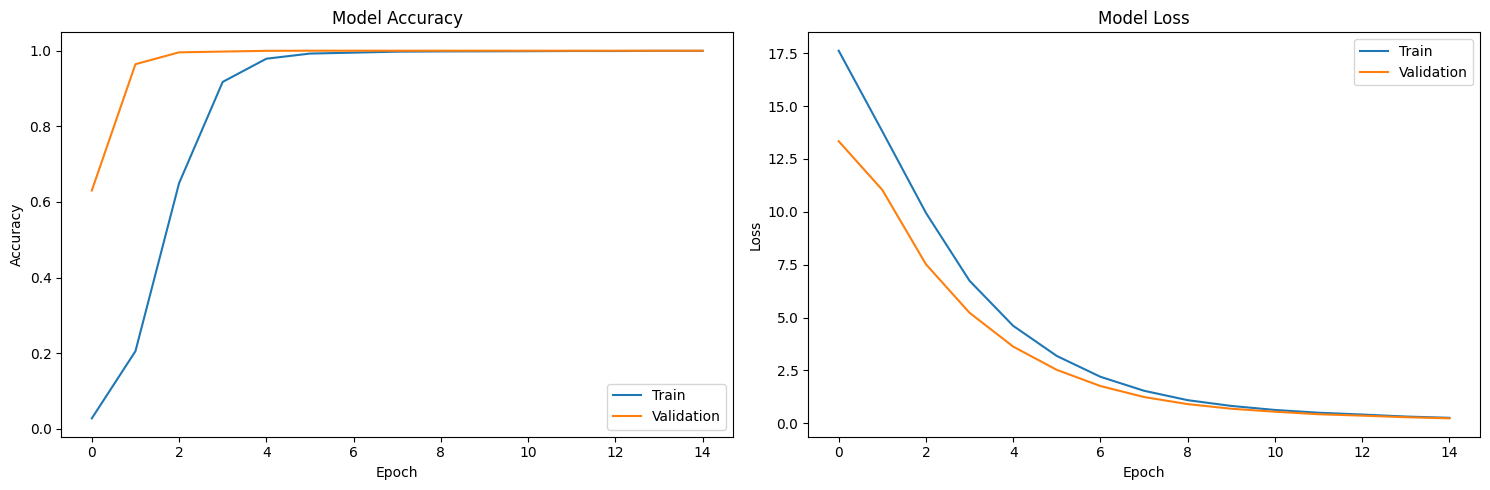

In [13]:
# Plot training history
plot_training_history(history)

In [14]:
# Evaluate model
test_loss, test_accuracy = model.evaluate(validation_generator)
print(f"\nTest accuracy: {test_accuracy:.4f}")

110/110 ━━━━━━━━━━━━━━━━━━━━ 12s 113ms/step - accuracy: 1.0000 - loss: 0.2310

Test accuracy: 1.0000


In [15]:
# Generate predictions
predictions = model.predict(validation_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = validation_generator.classes

110/110 ━━━━━━━━━━━━━━━━━━━━ 13s 115ms/step


In [16]:
# Print classification report
print("\nClassification Report:")
print(classification_report(
    true_classes,
    predicted_classes,
    target_names=list(train_generator.class_indices.keys())
))


Classification Report:
                          precision    recall  f1-score   support

105_classes_pins_dataset       1.00      1.00      1.00      3506

                accuracy                           1.00      3506
               macro avg       1.00      1.00      1.00      3506
            weighted avg       1.00      1.00      1.00      3506



In [17]:
# Function to predict single image
def predict_image(image_path):
    img = cv2.imread(image_path)
    if img is None:
        return None, None

    img = cv2.resize(img, (100, 100))
    img = img / 255.0
    img = np.expand_dims(img, axis=0)

    prediction = model.predict(img)
    class_idx = np.argmax(prediction[0])
    class_name = list(train_generator.class_indices.keys())[class_idx]
    confidence = prediction[0][class_idx]

    return class_name, confidence


In [18]:
# Save the model
model.save('face_recognition_model.keras')
print("\nModel saved as 'face_recognition_model.keras'")


Model saved as 'face_recognition_model.keras'
